In [ ]:
#if want to run this notebook in google colab you should uncomment the following commands
!pip install sms-tools
#!git clone https://github.com/MTG/sms-tools-materials.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.2/315.2 kB 4.6 MB/s eta 0:00:00


# Code


In [ ]:
import numpy as np
from scipy.signal import get_window, firwin, lfilter
from scipy.io import wavfile
from smstools.models import harmonicModel as HM
import IPython.display as ipd

def trim_audio(x, fs, start_time=0.3, duration=0.5):
    """
    Trim audio to specified start time and duration in seconds
    """
    start_sample = int(start_time * fs)
    duration_samples = int(duration * fs)
    return x[start_sample:start_sample + duration_samples]

def analyze_harmonics(x, fs):
    """
    Perform harmonic analysis using SMS-tools
    """
    # Analysis parameters
    window = 'blackman'
    M = 4096
    N = 4096
    t = -80  # dB threshold for harmonic detection
    nH = 100  # Maximum number of harmonics
    H = 256  # Hop size
    minf0 = 60
    maxf0 = 100
    f0et = 5

    # Perform analysis
    w = get_window(window, M)
    hfreq, hmag, hphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et)

    return hfreq, hmag, hphase

def synthesize_signal(x, fs, hfreq, hmag, morph_factor=1):
    """
    Synthesize audio signal using bandpass filtering approach
    """
    # Initialize array for filtered harmonics
    filtered_harmonics = np.zeros_like(x)

    # Step 1: Process each harmonic
    for i in range(hfreq.shape[1]):  # Loop over frames
        for j, freq in enumerate(hfreq[:, i]):
            if freq > 0 and freq < 7000:  # Only process harmonics up to 7 kHz
                # Get magnitude for this harmonic
                mag = hmag[j, i]
                if np.isnan(mag) or mag < -100:  # Skip very quiet or NaN harmonics
                    continue

                # Design bandpass filter
                bandwidth = 2 # 2hz
                nyquist = fs / 2
                low = (freq - bandwidth/2) / nyquist
                high = (freq + bandwidth/2) / nyquist
                if low >= 1.0 or high >= 1.0:  # Skip if frequencies exceed Nyquist
                    continue
                b = firwin(4001, [low, high], pass_zero=False)

                harmonic_signal = lfilter(b, 1, x)

                # Compute difference factor
                difference_factor = 10 ** (mag/20)

                # Compute the morphing for the filtered harmonic
                filtered_harmonics += harmonic_signal * difference_factor ** morph_factor

    # Step 2: Process high frequency noise
    nyquist = fs / 2
    high_freq_cutoff = 7000 / nyquist
    hp_filter = firwin(4001, high_freq_cutoff, pass_zero=False)
    high_freq_noise = lfilter(hp_filter, 1, x)

    # Step 3: Combine and trim
    synthesized_signal = filtered_harmonics + high_freq_noise

    # Normalize
    synthesized_signal = synthesized_signal / np.max(np.abs(synthesized_signal))

    return synthesized_signal


def spectral_morph(reference_signal, target_signal, fs, morph_level, num_morphing_steps=30):
    """
    Create morphed signal using SMS analysis and custom synthesis
    """
    # Analyze both signals
    ref_freq, ref_mag, ref_phase = analyze_harmonics(reference_signal, fs)
    target_freq, target_mag, target_phase = analyze_harmonics(target_signal, fs)

    # Compute morhping factor
    morph_factor = morph_level / num_morphing_steps

    # Compute magnitude difference between reference and target signals
    mag_diff = target_mag - ref_mag

    # Synthesize morphed signal
    morphed_signal = synthesize_signal(reference_signal, fs, ref_freq, mag_diff, morph_factor)

    return morphed_signal

def apply_attack_decay(signal, fs, attack_duration, decay_duration):
    """
    Apply linear attack and decay to a signal.
    """
    num_samples = len(signal)
    attack_samples = int(attack_duration * fs)
    decay_samples = int(decay_duration * fs)

    envelope = np.ones(num_samples)

    # Apply linear attack
    envelope[:attack_samples] = np.linspace(0, 1, attack_samples)

    # Apply linear decay
    envelope[-decay_samples:] = np.linspace(1, 0, decay_samples)

    return signal * envelope


def create_morphing_sequence(reference_file, target_file, output_prefix, num_steps=30):
    """
    Create sequence of morphed signals
    """
    # Read audio files
    fs_ref, ref_audio = wavfile.read(reference_file)
    fs_target, target_audio = wavfile.read(target_file)

    # Ensure same sampling rate
    assert fs_ref == fs_target, "Files must have same sampling rate"

    # Normalize signals
    ref_audio = ref_audio.astype(np.float32) / np.max(np.abs(ref_audio))
    target_audio = target_audio.astype(np.float32) / np.max(np.abs(target_audio))

    # Trim both signals to 0.5 seconds starting at 0.3 seconds
    ref_audio = trim_audio(ref_audio, fs_ref)
    target_audio = trim_audio(target_audio, fs_target)

    # Create morphed signals
    for level in range(1, num_steps + 1):
        print(f"Creating morph level {level}/{num_steps}")
        morphed = spectral_morph(ref_audio, target_audio, fs_ref, level, num_steps)
        morphed_attack_decay = apply_attack_decay(morphed, fs_ref, attack_duration=0.05, decay_duration=0.05)
        output_file = f"{output_prefix}_morph_{level:02d}.wav"
        wavfile.write(output_file, fs_ref, (morphed_attack_decay * 32767).astype(np.int16))

    return True

def test_morphing(reference_file, target_file):
    """
    Test the morphing system and play results
    """
    fs_ref, ref_audio = wavfile.read(reference_file)
    fs_target, target_audio = wavfile.read(target_file)

    # Normalize signals
    ref_audio = ref_audio.astype(np.float32) / np.max(np.abs(ref_audio))
    target_audio = target_audio.astype(np.float32) / np.max(np.abs(target_audio))

    # Trim both signals to 0.5 seconds starting at 0.3 seconds
    ref_audio = trim_audio(ref_audio, fs_ref)
    target_audio = trim_audio(target_audio, fs_target)

    # Create a test morph (50% between sounds)
    morphed = spectral_morph(ref_audio, target_audio, fs_ref, 15, 30)

    # Play original, morphed, and target sounds
    print("Reference Audio:")
    ipd.display(ipd.Audio(ref_audio, rate=fs_ref))
    print("Morphed Audio (50%):")
    ipd.display(ipd.Audio(morphed, rate=fs_ref))
    print("Target Audio:")
    ipd.display(ipd.Audio(target_audio, rate=fs_ref))

In [ ]:
test_morphing('BassTrombone.ff.E2.mono.wav', 'TenorTrombone.ff.E2.mono.wav')

Reference Audio:


Morphed Audio (50%):


Target Audio:


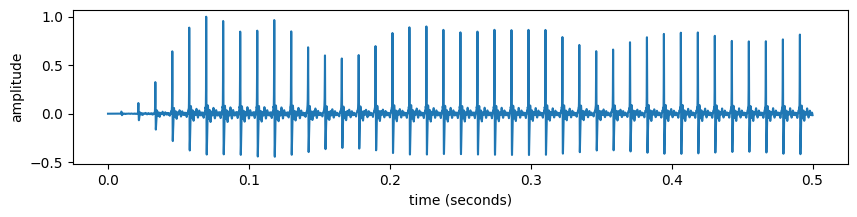

In [ ]:
from smstools.models import utilFunctions as UF
import matplotlib.pyplot as plt

input_file = "descarga.wav"
fs, x = UF.wavread(input_file)
plt.figure(0, figsize=(10, 2))
time_indexes = np.linspace(0, x.size/fs, x.size)
plt.plot(time_indexes, x)
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')
plt.show()
ipd.display(ipd.Audio(data=x, rate=fs))

In [ ]:
test_morphing('BassTrombone.ff.E2.mono.wav', 'TenorTrombone.ff.E2.mono.wav')

Reference Audio:


Morphed Audio (50%):


Target Audio:


In [ ]:
test_morphing('BassTrombone.ff.E2.mono.wav', 'TenorTrombone.ff.E2.mono.wav')

Reference Audio:


Morphed Audio (50%):


Target Audio:


In [ ]:
create_morphing_sequence('BassTrombone.ff.E2.mono.wav', 'TenorTrombone.ff.E2.mono.wav', "paper_trombone", 30)

Creating morph level 1/30
Creating morph level 2/30
Creating morph level 3/30
Creating morph level 4/30
Creating morph level 5/30
Creating morph level 6/30
Creating morph level 7/30
Creating morph level 8/30
Creating morph level 9/30
Creating morph level 10/30
Creating morph level 11/30
Creating morph level 12/30
Creating morph level 13/30
Creating morph level 14/30
Creating morph level 15/30
Creating morph level 16/30
Creating morph level 17/30
Creating morph level 18/30
Creating morph level 19/30
Creating morph level 20/30
Creating morph level 21/30
Creating morph level 22/30
Creating morph level 23/30
Creating morph level 24/30
Creating morph level 25/30
Creating morph level 26/30
Creating morph level 27/30
Creating morph level 28/30
Creating morph level 29/30
Creating morph level 30/30


True

In [ ]:
for i in range(30):
  file_name = f"paper_trombone_morph_{i+1:02d}.wav"
  fs, x = wavfile.read(file_name)
  ipd.display(ipd.Audio(x, rate=fs))